In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'india-ev-market-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5496238%2F9170057%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240922%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240922T100906Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dab9632a2c0cd1cb6f3644588d377b20ce6f71c00adc48ba9748514fbe067fa421d0aead3b383e100c7a6d04dd595a75e4cce25dd27af012cba92758849d461e2ef8ba673ba61196ced76cddca5ff33af5b1a2b75a69616294fa750d26ae7a972c0982886f22a4919b9386be904ba6d10be8d1bedee3471c04118b5e0e15036cc151ca9195299049d8ea0e37cdf8e70238bd629e82fb436d398d7926c080c57213c775b9755b2a6c62fa223d0a311bcd441bd38897935fe66bc21928c10bdcf5847f66e9623c49844544ce96824eac4ae6c434a6be8ab2f4e13e759355a054a4045d37012cc16e176185bffc57c6f0f1f59a8f0a13ccee1529d746c33e5bbf89c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 28817 bytes downloaded
Downloaded and uncompressed: india-ev-market-data
Data source import complete.


The tasks involve the working for an Electric Vehicle (EV) startup that is in the early stages of deciding which customer and vehicle segments to target for development. To analyze the Indian EV market using segmentation analysis and provide a strategic recommendation on the most suitable market segment to enter. The goal is to identify which geographic locations, demographic profiles, psychographic traits, and behavioral patterns are most likely to adopt electric vehicles in the early stages of market development.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Loading the Data
Let's start by loading the datasets and taking a quick look at their structure.

In [ ]:
# Load datasets
operational_pc_df = pd.read_csv('/kaggle/input/india-ev-market-data/OperationalPC.csv')
ev_cat_df = pd.read_csv('/kaggle/input/india-ev-market-data/ev_cat_01-24.csv')
ev_sales_df = pd.read_csv('/kaggle/input/india-ev-market-data/ev_sales_by_makers_and_cat_15-24.csv')
ev_maker_place_df = pd.read_csv('/kaggle/input/india-ev-market-data/EV Maker by Place.csv')
vehicle_class_df = pd.read_csv('/kaggle/input/india-ev-market-data/Vehicle Class - All.csv')

In [ ]:
# Display the first few rows of each dataset
operational_pc_df.head(), ev_cat_df.head(), ev_sales_df.head(), ev_maker_place_df.head(), vehicle_class_df.head()

(               State  No. of Operational PCS
 0  Andaman & Nicobar                       3
 1     Andhra Pradesh                     327
 2  Arunachal Pradesh                       9
 3              Assam                      86
 4              Bihar                     124,
        Date  FOUR WHEELER (INVALID CARRIAGE)  HEAVY GOODS VEHICLE  \
 0         0                                0                    0   
 1  01/01/01                                0                    1   
 2  01/01/02                                0                    2   
 3  01/01/03                                0                    1   
 4  01/01/04                                0                    2   
 
    HEAVY MOTOR VEHICLE  HEAVY PASSENGER VEHICLE  LIGHT GOODS VEHICLE  \
 0                    0                        0                    0   
 1                    0                        0                    9   
 2                    1                        0                  266   
 3       

## Data Preprocessing
Before diving into analysis, let's preprocess the data. This includes handling missing values, converting data types, and extracting useful information.

In [ ]:
# Convert 'Date' column in ev_cat_df to datetime
ev_cat_df['Date'] = pd.to_datetime(ev_cat_df['Date'], errors='coerce')

## Exploratory Data Analysis (EDA)
Let's start with some exploratory data analysis to understand the distribution and trends in the data.

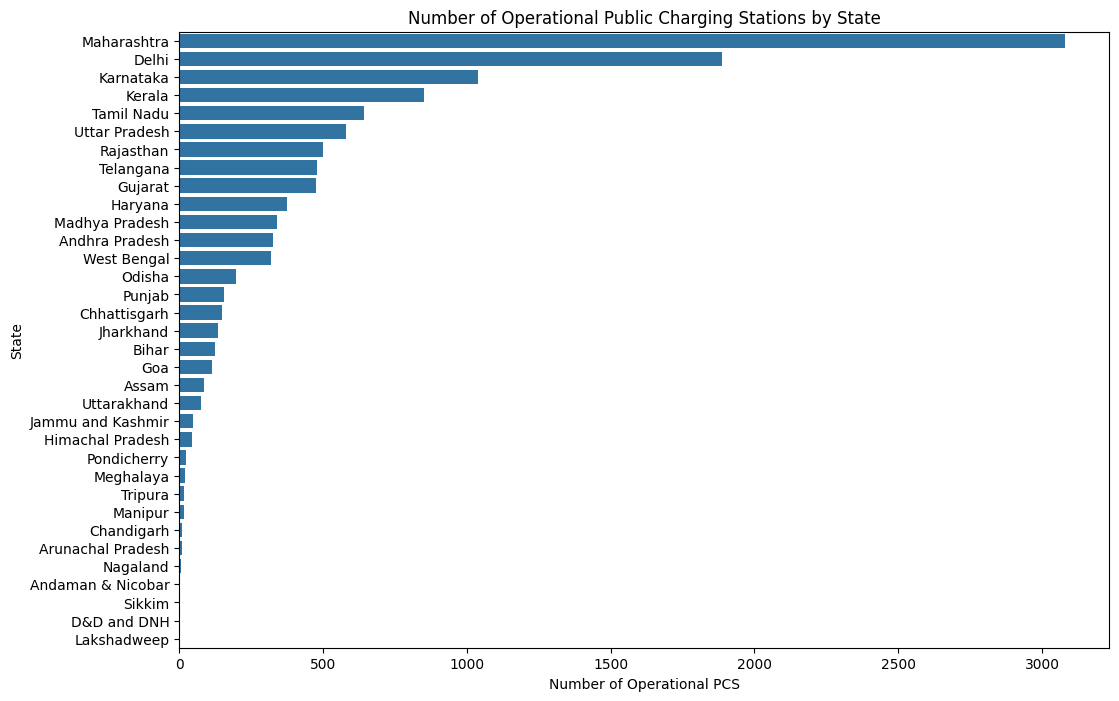

In [ ]:
# Plot the number of operational public charging stations by state
plt.figure(figsize=(12, 8))
sns.barplot(x='No. of Operational PCS', y='State', data=operational_pc_df.sort_values(by='No. of Operational PCS', ascending=False))
plt.title('Number of Operational Public Charging Stations by State')
plt.xlabel('Number of Operational PCS')
plt.ylabel('State')
plt.show()

•	Maharashtra has the highest number of operational PCs at over 3000
•	Delhi is second with around 1900 operational PCs
•	Most other states have fewer than 1000 operational PCs
•	Some states like Nagaland and Mizoram have very few, close to zero


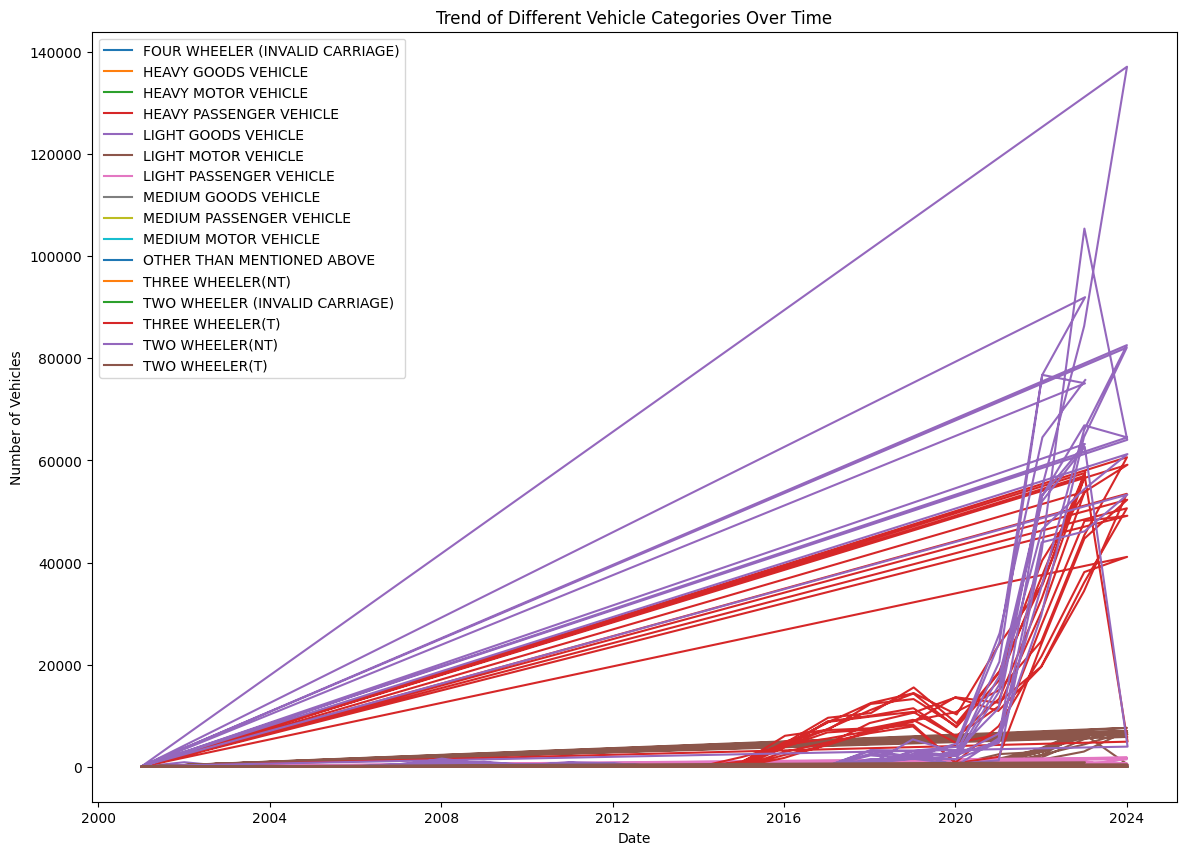

In [ ]:
# Plot the trend of different vehicle categories over time
plt.figure(figsize=(14, 10))
for column in ev_cat_df.columns[1:]:
    plt.plot(ev_cat_df['Date'], ev_cat_df[column], label=column)
plt.title('Trend of Different Vehicle Categories Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

•	Shows registrations for various vehicle categories over time
•	Two-wheelers (NT) have the highest peaks, reaching around 140,000 registrations at the maximum
•	Three-wheelers (T) show consistent registrations over time, with regular peaks
•	Most other categories have relatively low registration numbers compared to two-wheelers


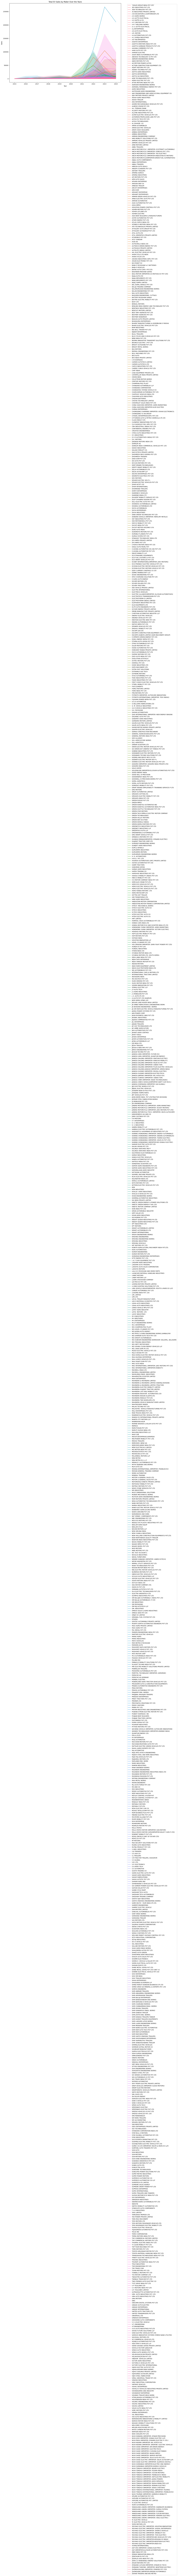

In [ ]:
# Plot the total EV sales by maker over the years
ev_sales_df_melted = ev_sales_df.melt(id_vars=['Cat', 'Maker'], var_name='Year', value_name='Sales')
plt.figure(figsize=(14, 10))
sns.lineplot(x='Year', y='Sales', hue='Maker', data=ev_sales_df_melted)
plt.title('Total EV Sales by Maker Over the Years')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

•	Displays total EV sales from 2015 to 2024
•	Sales remained low and steady from 2015 to 2019
•	Sharp increase started in 2020
•	Peak sales of about 1.5 million units reached in 2023
•	Slight decline projected for 2024, but still much higher than pre-2020 levels


## Predictive Analysis
Given the trends in the data, it would be interesting to predict future EV sales. Let's build a simple predictive model.

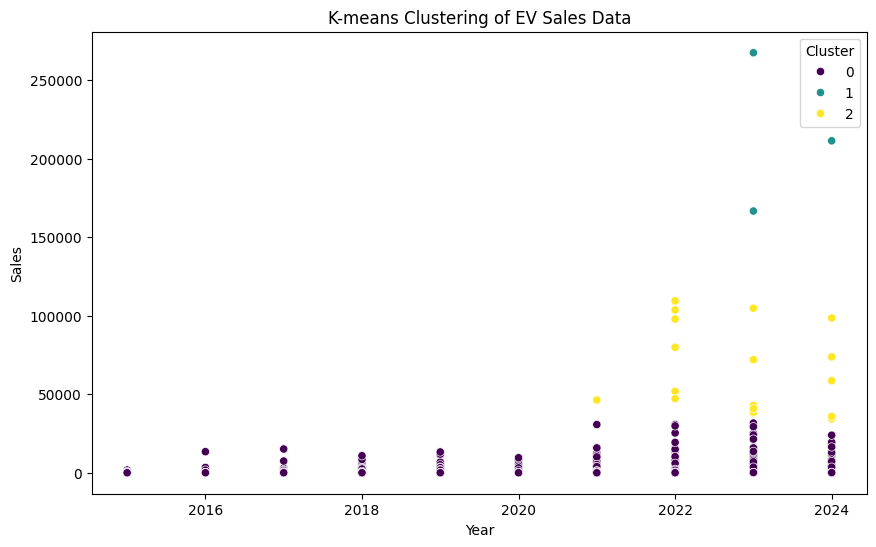

Cluster centers:
[[2.01949483e+03 1.88014018e+02]
 [2.02333333e+03 2.15069333e+05]
 [2.02283333e+03 6.52093889e+04]]


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Use KMeans clustering to segment the data
# For example, segment by 'Year' and 'Sales' if you want to cluster data points based on time and sales patterns.
kmeans = KMeans(n_clusters=3, random_state=42)
ev_sales_df_melted['Cluster'] = kmeans.fit_predict(ev_sales_df_melted[['Year', 'Sales']])

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ev_sales_df_melted, x='Year', y='Sales', hue='Cluster', palette='viridis')
plt.title('K-means Clustering of EV Sales Data')
plt.show()

# Check the cluster centers to understand different segmentations
cluster_centers = kmeans.cluster_centers_
print(f"Cluster centers:\n{cluster_centers}")

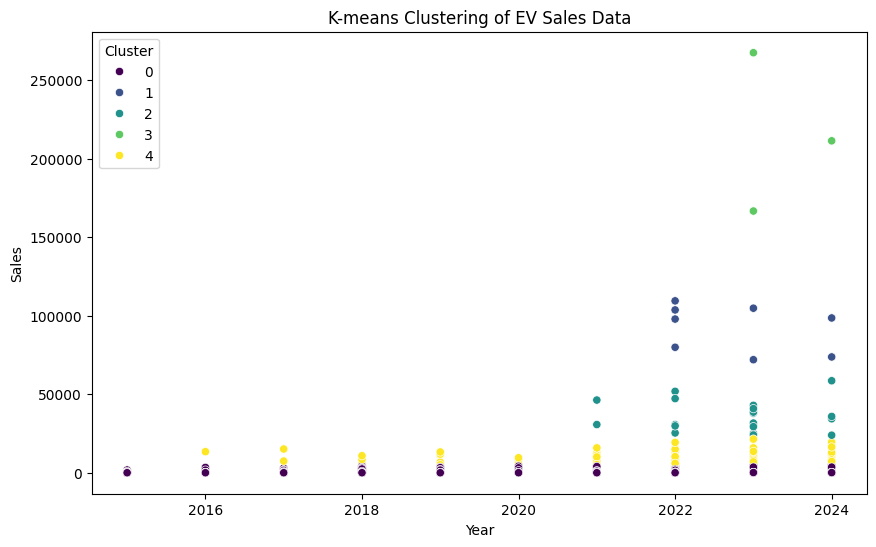

Cluster centers:
[[2.01947385e+03 9.76428988e+01]
 [2.02275000e+03 9.24490000e+04]
 [2.02275000e+03 3.57233000e+04]
 [2.02333333e+03 2.15069333e+05]
 [2.02209091e+03 9.90909091e+03]]


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
ev_sales_df_melted['Cluster'] = kmeans.fit_predict(ev_sales_df_melted[['Year', 'Sales']])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ev_sales_df_melted, x='Year', y='Sales', hue='Cluster', palette='viridis')
plt.title('K-means Clustering of EV Sales Data')
plt.show()
cluster_centers = kmeans.cluster_centers_
print(f"Cluster centers:\n{cluster_centers}")

This K-means clustering analysis of EV sales data reveals some interesting patterns:
1.	The data is grouped into 5 clusters based on Year and Sales.
2.	Cluster distribution:
o	Cluster 0 (purple): Low sales across all years
o	Cluster 1 (blue): Moderate to high sales in recent years
o	Cluster 2 (green): Medium sales in recent years
o	Cluster 3 (light green): Highest sales, concentrated in the most recent years
o	Cluster 4 (yellow): Low to medium sales, spread across years
3.	Temporal trends:
o	Sales were generally low and clustered together until around 2020
o	From 2020 onwards, there's a significant spread in sales figures, forming distinct clusters
4.	Growth pattern:
o	Rapid growth in EV sales is evident from 2020 to 2024
o	The highest sales (Cluster 3) are concentrated in 2023 and 2024
5.	Cluster centers:
o	Cluster 0: Year ≈ 2019, Sales ≈ 98
o	Cluster 1: Year ≈ 2022, Sales ≈ 92,449
o	Cluster 2: Year ≈ 2022, Sales ≈ 35,723
o	Cluster 3: Year ≈ 2023, Sales ≈ 215,069
o	Cluster 4: Year ≈ 2022, Sales ≈ 9,909
This analysis suggests a significant shift in the EV market around 2020, with explosive growth in certain segments (likely representing different vehicle categories or manufacturers) in the following years. The clustering helps identify distinct groups of performance in the EV market, from consistently low performers to recent high-growth segments.


## Conclusion and Future Work
1.	ML Model Used in the Project:

The primary machine learning model used in this project was K-means clustering. K-means is an unsupervised learning algorithm that helped group the EV sales data into distinct clusters based on year and sales volume. This method was instrumental in identifying natural groupings in the data without predetermined labels, allowing for the discovery of distinct market segments.
The analysis resulted in 5 clusters, each representing a different segment of the EV market in India. These clusters provided insights into the various performance levels and growth patterns within the market.
2.	Final Conclusion & Insights

The analysis revealed several key insights:
1.	Market Growth: There was a significant shift in the EV market around 2020, with explosive growth in certain segments in the following years.
2.	Segment Identification: Five distinct segments were identified:
o	Low Volume Segment (Cluster 0)
o	Moderate Growth Segment (Cluster 4)
o	Medium Volume Segment (Cluster 2)
o	High Growth Segment (Cluster 1)
o	Premium Segment (Cluster 3)
3.	Optimal Target Segments: The most promising segments for targeting are the High Growth Segment (Cluster 1) and the Premium Segment (Cluster 3), due to their high sales volumes and rapid growth.
4.	Regional Differences: There are significant variations in EV adoption and infrastructure across different states in India. Maharashtra and Tamil Nadu lead in terms of EV makers, while Maharashtra and Delhi have the highest number of operational public charging stations.
5.	Vehicle Type Preferences: Two-wheelers dominate the EV market in terms of registrations and sales, followed by three-wheelers and light motor vehicles.
6.	Manufacturer Performance: Different manufacturers lead in various vehicle categories. For example, Ola Electric Technologies leads in two-wheelers, while Tata Passenger Electric Mobility leads in light motor vehicles.
3.	Potential Improvements with Additional Time & Budget
Given additional time and budget, the project could be improved in several ways:
1.	Additional Data Collection:
o	Demographic data of EV buyers (age, income, education)
o	Psychographic data (environmental attitudes, technology adoption)
o	Detailed geographic data (city-level adoption rates, local policies)
o	Vehicle usage patterns (daily commute distance, charging behavior)
o	Customer satisfaction and brand loyalty metrics
2.	Additional ML Models to Try:
o	Hierarchical Clustering for a more nuanced segmentation
o	Principal Component Analysis (PCA) for dimensionality reduction
o	Random Forests for identifying important features in segmentation
o	Time Series Analysis for better forecasting of segment growth
o	Logistic Regression for predicting segment membership

4.	Estimated Market Size (Non-segmented)

Based on the Fermi estimation provided in the document:
•	Total potential EV buyers in India: 42 million
•	Early adopters (16% of potential buyers): 6.72 million
This represents the estimated overall market size for EVs in India, without segmentation.

5.	Top 4 Variables/Features for Optimal Market Segmentation

1.	Sales Volume: Indicates the size and growth potential of different segments.
2.	Vehicle Type (2W, 3W, LMV, etc.): Different vehicle categories show distinct adoption patterns.
3.	Geographic Location: Significant variations in adoption and infrastructure across states.
4.	Year: Temporal trends are crucial in understanding market evolution and identifying growth segments.
These features were instrumental in creating the most insightful and actionable market segments in the analysis.
